# 1_데이터 불러오기

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 30)
import warnings
warnings.filterwarnings('ignore')
from my_func import *

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc("font",family="Malgun Gothic")  ## 폰트       한글 깨짐
plt.rc("axes",unicode_minus=False)     ## 폰트 minus 부호 깨짐
plt.style.use("ggplot")

In [3]:
df0 = pd.read_csv( r"data\[이어드림스쿨] 차이코퍼레이션 데이터.csv" ) #---- raw data
df1 = pd.read_parquet( r"data\pre_buy.parquet" ) #----------------------- 거래건별: 날짜 > id 순
df2 = pd.read_parquet( r"data\pre_personal.parquet" ) #-------------------- 개인별: id 순

print(f"df0__{df0.shape[0]:,}", f"df1__{df1.shape[0]:,}", f"df2__{df2.shape[0]:,}", sep="        " )
display(df0.head(2))
display(df1.head(2))
display(df2.head(2))

df0__5,623,810        df1__5,623,810        df2__544,921


,customer_id,created_at,pre_discount,post_discount,cashback_amount,discount_amount,total_promotion,push_permission,gender,is_foreigner,birthday,sign_up_date,merchant_id
0,207317,2020-03-22 10:27:52.498,36236,36236,1087,0,1087,True,female,False,1957-11-05,2019-11-30 16:48:19.339,9
1,95246,2020-03-12 09:41:09.845,12900,12900,387,0,387,True,female,False,1983-10-23,2019-07-09 08:21:14.098,6


,id,buy,before,after,back,discnt,total,push,male,foreigner,birth,sign_up,merchant,buy_y,buy_m,buy_d,buy_7,sign_y,sign_m,sign_d,age,b_rate,d_rate,t_rate,cnt_b
0,21,2019-08-01,10900,5900,0,5000,5000,0,0,0,1988-05-12,2019-06-24,4,2019,8,1,4,2019,6,24,32,0.0,45.87,45.87,1
1,33,2019-08-01,14500,9500,0,5000,5000,0,1,0,1983-11-26,2019-07-05,7,2019,8,1,4,2019,7,5,37,0.0,34.48,34.48,1


,id,male,age,push,foreigner,cnt_b,before,after,back,discnt,total,birth,sign_up,sign_y,sign_m,sign_d,mc1,mc2,mc3,mc4,mc5,mc6,mc7,mc8,mc9,mc10,cnt_p,b_rate,d_rate,t_rate
0,1,0,34,0,0,2,24330,18960,0,5370,5370,1986-03-26,2019-08-25,2019,8,25,0,1,0,0,0,1,0,0,0,0,1,0.0,22.07,22.07
1,2,0,25,0,0,2,25030,19359,0,5671,5671,1995-07-03,2019-08-09,2019,8,9,0,0,0,0,0,0,1,0,1,0,1,0.0,22.66,22.66


In [6]:
data = df2[["id","cnt_b"]]
data = data.sort_values(by="cnt_b",ascending=False)
data.head(5)

,id,cnt_b
45418,45419,2705
445690,445691,2630
485909,485910,1684
400417,400418,1363
96305,96306,1229


# 2_유의미한 feature 찾기

### 1_거래건 분포: 요일별

In [361]:
### 요일별 구매건수
N,F,M = len(df1), len(df1.loc[df1.male==0]), len(df1.loc[df1.male==1])
data1 = df1[["buy_7","cnt_b","male"]]
data1 = pd.get_dummies(  data=data1, columns=["male"]  )
data1 = data1.groupby("buy_7").sum()
data1[["cnt_b","male_0","male_1"]] = data1[["cnt_b","male_0","male_1"]].astype(np.int32)
data1["ALL"] = round(  100*data1["cnt_b"] / N, 1  )
data1["F"] = round(  100*data1["male_0"] / F, 1  )
data1["M"] = round(  100*data1["male_1"] / M, 1  )
data1 = data1.reset_index()
data1.index = ["일","월","화","수","목","금","토",]
data1

,buy_7,cnt_b,male_0,male_1,ALL,F,M
일,0,721591,520055,201536,12.8,12.8,13.0
월,1,1032577,724372,308205,18.4,17.8,19.8
화,2,820446,604553,215893,14.6,14.9,13.9
수,3,798752,587653,211099,14.2,14.4,13.6
목,4,813331,587114,226217,14.5,14.4,14.6
금,5,811818,596657,215161,14.4,14.7,13.8
토,6,625295,449673,175622,11.1,11.0,11.3


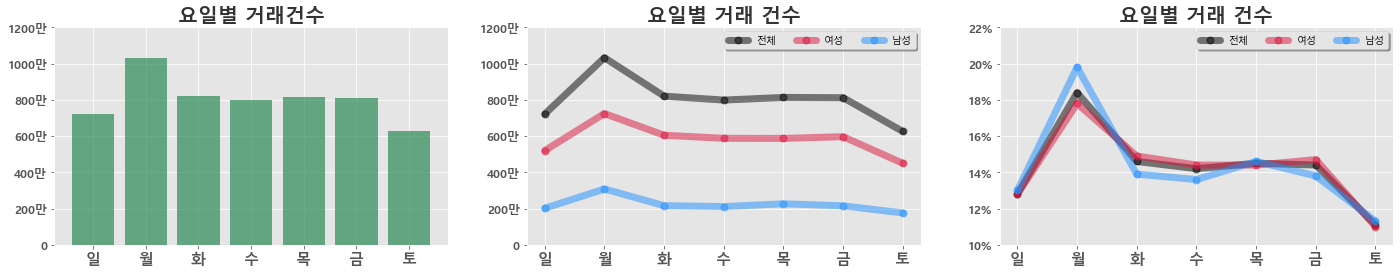

In [366]:
### 
plt.figure(figsize=((24,4)))
plt.subplot(1,3,1)
plt.bar( data1.buy_7, data1.cnt_b, color ='seagreen', alpha=0.7, )
plt.xticks(range(7), ["일","월","화","수","목","금","토",], size=15, weight=1000, )
plt.yticks(range(0,1400000,200000),[0]+[f"{i}00만" for i in range(2,14,2)], size=12, weight=1000, )
plt.xlabel("", weight=1000, size=15, loc="right", )
plt.ylabel("", weight=1000, size=15, rotation=90, loc="top", )
plt.title("요일별 거래건수", weight=1000, color="k", size=20, alpha=0.8, pad=-35, loc="center", )

plt.subplot(1,3,2)
plt.plot( data1.buy_7, data1.cnt_b, label="전체", alpha=0.5, lw=7, ls="-",  color ="k",     marker='o', ms=7, mfc="k",      solid_capstyle='round' )
plt.plot( data1.buy_7, data1.male_0, label="여성", alpha=0.5, lw=7, ls="-",  color ="Crimson",     marker='o', ms=7, mfc="Crimson",      solid_capstyle='round' )
plt.plot( data1.buy_7, data1.male_1, label="남성", alpha=0.5, lw=7, ls="-",  color ="dodgerblue",     marker='o', ms=7, mfc="dodgerblue",      solid_capstyle='round' )
plt.xticks(range(7), ["일","월","화","수","목","금","토",], size=15, weight=1000, )
plt.yticks(range(0,1400000,200000),[0]+[f"{i}00만" for i in range(2,14,2)], size=12, weight=1000, )
plt.xlabel("", weight=1000, size=15, loc="right", )
plt.ylabel("", weight=1000, size=15, rotation=90, loc="top", )
plt.title("요일별 거래 건수", weight=1000, color="k", size=20, alpha=0.8, pad=-35, loc="center", )
plt.legend(loc=(0.5,0.9), ncol=3, fontsize=10, frameon=True, shadow=True)

plt.subplot(1,3,3)
plt.plot( data1.buy_7, data1.ALL, label="전체", alpha=0.5, lw=7, ls="-",  color ="k",     marker='o', ms=7, mfc="k",      solid_capstyle='round' )
plt.plot( data1.buy_7, data1.F, label="여성", alpha=0.5, lw=7, ls="-",  color ="Crimson",     marker='o', ms=7, mfc="Crimson",      solid_capstyle='round' )
plt.plot( data1.buy_7, data1.M, label="남성", alpha=0.5, lw=7, ls="-",  color ="dodgerblue",     marker='o', ms=7, mfc="dodgerblue",      solid_capstyle='round' )
plt.xticks(range(7), ["일","월","화","수","목","금","토",], size=15, weight=1000, )
plt.yticks(range(10,24,2),[f"{i}%" for i in range(10,24,2)], size=12, weight=1000, )
plt.xlabel("", weight=1000, size=15, loc="right", )
plt.ylabel("", weight=1000, size=15, rotation=90, loc="top", )
plt.title("요일별 거래 건수", weight=1000, color="k", size=20, alpha=0.8, pad=-35, loc="center", )
plt.legend(loc=(0.5,0.9), ncol=3, fontsize=10, frameon=True, shadow=True)

plt.show()

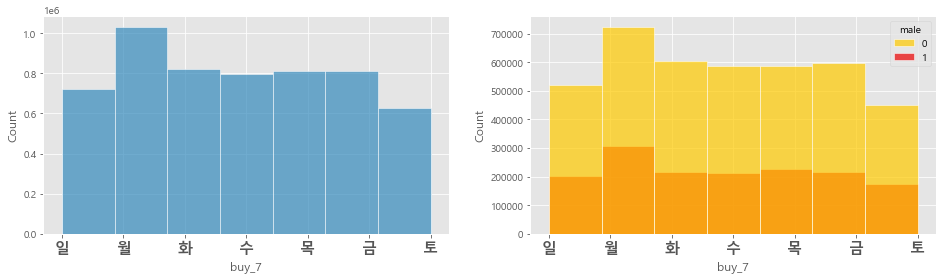

In [37]:
### 히스토그램 x눈금 씽크가 거슬려..
plt.figure(figsize=((16,4)))
plt.subplot(1,2,1)
sns.histplot( data=df1, x=df1.buy_7, bins=7, palette ='hot_r', alpha=0.7, edgecolor='w', )
plt.xticks(range(7), ["일","월","화","수","목","금","토",], size=15, weight=1000, )

plt.subplot(1,2,2)
sns.histplot( data=df1, x=df1.buy_7, bins=7, palette ='hot_r', alpha=0.7, edgecolor='w', hue="male" )
plt.xticks(range(7), ["일","월","화","수","목","금","토",], size=15, weight=1000, )
plt.show()

### 2 거래건 분포: 연령대별

In [105]:
display(df0.head(2))
display(df1.head(2))
display(df2.head(2))

,customer_id,created_at,pre_discount,post_discount,cashback_amount,discount_amount,total_promotion,push_permission,gender,is_foreigner,birthday,sign_up_date,merchant_id
0,207317,2020-03-22 10:27:52.498,36236,36236,1087,0,1087,True,female,False,1957-11-05,2019-11-30 16:48:19.339,9
1,95246,2020-03-12 09:41:09.845,12900,12900,387,0,387,True,female,False,1983-10-23,2019-07-09 08:21:14.098,6


,id,buy,before,after,back,discnt,total,push,male,foreigner,birth,sign_up,merchant,buy_y,buy_m,buy_d,buy_7,sign_y,sign_m,sign_d,age,b_rate,d_rate,t_rate,cnt_b
0,21,2019-08-01,10900,5900,0,5000,5000,0,0,0,1988-05-12,2019-06-24,4,2019,8,1,4,2019,6,24,32,0.0,45.87,45.87,1
1,33,2019-08-01,14500,9500,0,5000,5000,0,1,0,1983-11-26,2019-07-05,7,2019,8,1,4,2019,7,5,37,0.0,34.48,34.48,1


,id,male,age,push,foreigner,cnt_b,before,after,back,discnt,total,birth,sign_up,sign_y,sign_m,sign_d,mc1,mc2,mc3,mc4,mc5,mc6,mc7,mc8,mc9,mc10,cnt_p,b_rate,d_rate,t_rate
0,1,0,34,0,0,2,24330,18960,0,5370,5370,1986-03-26,2019-08-25,2019,8,25,0,1,0,0,0,1,0,0,0,0,1,0.0,22.07,22.07
1,2,0,25,0,0,2,25030,19359,0,5671,5671,1995-07-03,2019-08-09,2019,8,9,0,0,0,0,0,0,1,0,1,0,1,0.0,22.66,22.66


In [191]:
### 0 ~ 130 세: 10년 단위 계급값으로 분포 조회
data1 = df1['age']
freq1, range1 = np.histogram(data1, bins=13, range=(0,130))
print(freq1, type(freq1), "\n", sep="\n")
print(range1, type(range1), sep="\n")

[      0   33913 1158126 2181618 1663656  459491   99547   14899    3394
     247       6       0    8913]
<class 'numpy.ndarray'>


[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.]
<class 'numpy.ndarray'>


In [195]:
### x: 인덱스 수작업 하기 (각 구간 a <= x < b)
index1 = [f'{i} ~ {i+10}' for i in range(0,130,10) ]
print(index1, type(index1))

['0 ~ 10', '10 ~ 20', '20 ~ 30', '30 ~ 40', '40 ~ 50', '50 ~ 60', '60 ~ 70', '70 ~ 80', '80 ~ 90', '90 ~ 100', '100 ~ 110', '110 ~ 120', '120 ~ 130'] <class 'list'>


In [197]:
### x: 인덱스 수작업 하기 (각 구간 a <= x < b)
index1 = ["10살미만"]+[f'{i}代' for i in range(10,130,10) ]
print(index1, type(index1))

['10살미만', '10代', '20代', '30代', '40代', '50代', '60代', '70代', '80代', '90代', '100代', '110代', '120代'] <class 'list'>


In [198]:
### 도수분포표 만들기
data2 = pd.DataFrame( {"frequence":freq1},
                    index = pd.Index(index1, name='class') )
N = len(df1)
data2["rate"] = round(100*data2.frequence/N,1)
data2

,frequence,rate
class,,
10살미만,0,0.0
10代,33913,0.6
20代,1158126,20.6
30代,2181618,38.8
40代,1663656,29.6
50代,459491,8.2
60代,99547,1.8
70代,14899,0.3
80代,3394,0.1


In [199]:
data2 = data2.sort_values(by="frequence",ascending=False)
data2

,frequence,rate
class,,
30代,2181618,38.8
40代,1663656,29.6
20代,1158126,20.6
50代,459491,8.2
60代,99547,1.8
10代,33913,0.6
70代,14899,0.3
120代,8913,0.2
80代,3394,0.1


In [202]:
### 지저분한 기타 범주들 무시하기 위한 작업
# idx = ['30 ~ 40', '40 ~ 50', '20 ~ 30', '50 ~ 60']
idx = ['30代', '40代', '20代', '50代']

In [203]:
data2["name"] = data2.index
data2["name"] = data2["name"].apply(lambda x:x if x in idx else "")
data2

,frequence,rate,name
class,,,
30代,2181618,38.8,30代
40代,1663656,29.6,40代
20代,1158126,20.6,20代
50代,459491,8.2,50代
60代,99547,1.8,
10代,33913,0.6,
70代,14899,0.3,
120代,8913,0.2,
80代,3394,0.1,


In [207]:
### 5% 미만 합친 data3

data21 = data2.iloc[:4,:]
# display(data21) #--------------

data22 = data2[["frequence"]].iloc[4:,:]
data22["cnt"] = 1
data22 = data22.groupby("cnt").sum()
data22.index = ["etc"]
N = len(df1)
data22["rate"] = round(100*data22.frequence/N,1)
data22["name"] = "etc"
# display(data22) #---------------

data3 = pd.concat([data21,data22], axis=0)
data3


,frequence,rate,name
30代,2181618,38.8,30代
40代,1663656,29.6,40代
20代,1158126,20.6,20代
50代,459491,8.2,50代
etc,160919,2.9,etc


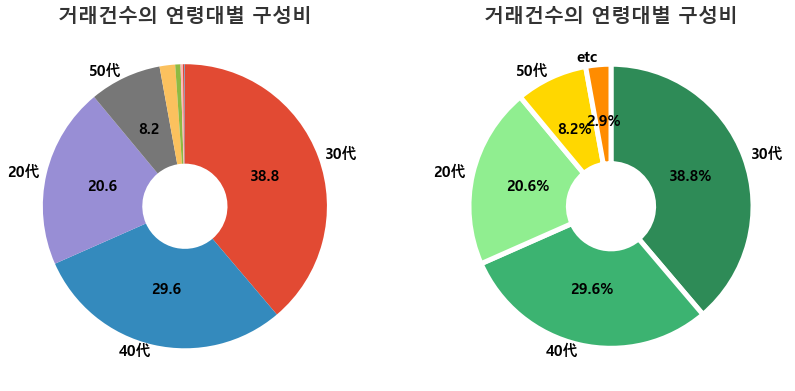

In [214]:
ratio = data2.frequence
x_name = data2.name
x_wedgeprops = {'width':0.7, }
x_textprops = {"size":15, "color":"k", "weight":1000, }

plt.figure(figsize=((14,7)))
plt.subplot(1,2,1)
plt.pie(ratio, labels=x_name,
        startangle=90, counterclock=False,
        wedgeprops=x_wedgeprops, textprops=x_textprops,
        autopct=lambda x:f"{x:.1f}" if x>5 else " ", labeldistance=1.05, )
plt.title("거래건수의 연령대별 구성비", weight=1000, color="k", size=20, alpha=0.8, loc="center", )

ratio = data3.frequence
x_name = data3.index
x_color = ['SeaGreen','MediumSeaGreen','LightGreen',"gold","DarkOrange"]
x_wedgeprops = {'width':0.7, 'edgecolor':'w', 'linewidth':5}

plt.subplot(1,2,2)
plt.pie(ratio, labels=x_name, colors=x_color,
        startangle=90, counterclock=False, rotatelabels=False,
        wedgeprops=x_wedgeprops, textprops=x_textprops,
        autopct='%.1f%%', labeldistance=1.05, )
plt.title("거래건수의 연령대별 구성비", weight=1000, color="k", size=20, alpha=0.8, loc="center", )
plt.show()

### 3_연령대별 거래 정보

In [232]:
display(df0.head(2))
display(df1.head(2))
display(df2.head(2))

,customer_id,created_at,pre_discount,post_discount,cashback_amount,discount_amount,total_promotion,push_permission,gender,is_foreigner,birthday,sign_up_date,merchant_id
0,207317,2020-03-22 10:27:52.498,36236,36236,1087,0,1087,True,female,False,1957-11-05,2019-11-30 16:48:19.339,9
1,95246,2020-03-12 09:41:09.845,12900,12900,387,0,387,True,female,False,1983-10-23,2019-07-09 08:21:14.098,6


,id,buy,before,after,back,discnt,total,push,male,foreigner,birth,sign_up,merchant,buy_y,buy_m,buy_d,buy_7,sign_y,sign_m,sign_d,age,b_rate,d_rate,t_rate,cnt_b
0,21,2019-08-01,10900,5900,0,5000,5000,0,0,0,1988-05-12,2019-06-24,4,2019,8,1,4,2019,6,24,32,0.0,45.87,45.87,1
1,33,2019-08-01,14500,9500,0,5000,5000,0,1,0,1983-11-26,2019-07-05,7,2019,8,1,4,2019,7,5,37,0.0,34.48,34.48,1


,id,male,age,push,foreigner,cnt_b,before,after,back,discnt,total,birth,sign_up,sign_y,sign_m,sign_d,mc1,mc2,mc3,mc4,mc5,mc6,mc7,mc8,mc9,mc10,cnt_p,b_rate,d_rate,t_rate
0,1,0,34,0,0,2,24330,18960,0,5370,5370,1986-03-26,2019-08-25,2019,8,25,0,1,0,0,0,1,0,0,0,0,1,0.0,22.07,22.07
1,2,0,25,0,0,2,25030,19359,0,5671,5671,1995-07-03,2019-08-09,2019,8,9,0,0,0,0,0,0,1,0,1,0,1,0.0,22.66,22.66


In [4]:
### int 한도 16, 32 ---> 64
data1 = df2[['id', 'male', 'age', 'push', 'foreigner', 'cnt_b', 'before', 'after', 'back', 'discnt', 'total',
            'mc1', 'mc2', 'mc3', 'mc4', 'mc5', 'mc6', 'mc7', 'mc8', 'mc9', 'mc10', 'cnt_p']].astype(np.int64)

### 나이대 feature 생성
data1["AGE"] = data1["age"] // 10
data1.head(3)

,id,male,age,push,foreigner,cnt_b,before,after,back,discnt,total,mc1,mc2,mc3,mc4,mc5,mc6,mc7,mc8,mc9,mc10,cnt_p,AGE
0,1,0,34,0,0,2,24330,18960,0,5370,5370,0,1,0,0,0,1,0,0,0,0,1,3
1,2,0,25,0,0,2,25030,19359,0,5671,5671,0,0,0,0,0,0,1,0,1,0,1,2
2,3,1,39,1,0,1,18120,13440,0,4680,4680,0,0,0,1,0,0,0,0,0,0,1,3


In [5]:
### 합계 낼 피쳐
col_sum = ['cnt_b', 'before', 'after', 'back', 'discnt', 'total',
            'mc1', 'mc2', 'mc3', 'mc4', 'mc5', 'mc6', 'mc7', 'mc8', 'mc9', 'mc10', 'cnt_p', 'AGE']

### 평균 낼 피쳐
col_mean = ['male', 'age', 'push', 'foreigner', 'AGE']

In [6]:
### 연령대별 합계
data_s = data1[col_sum]
data_s = data_s.groupby("AGE").sum()
print(data_s.shape)
display(data_s.head(3))

### 연령대별 평균
data_m = data1[col_mean]
data_m = data_m.groupby("AGE").mean()
print(data_m.shape)
display(data_m.head(3))

data_m["age"] = data_m["age"].apply(int)
data_m[["male","push","foreigner"]] = data_m[["male","push","foreigner"]].apply(lambda x:round(100*x,1))
print(data_m.shape)
display(data_m.head(3))

(11, 17)


,cnt_b,before,after,back,discnt,total,mc1,mc2,mc3,mc4,mc5,mc6,mc7,mc8,mc9,mc10,cnt_p
AGE,,,,,,,,,,,,,,,,,
1,25502,412391209,379609491,2143578,32781718,34925296,1502,2696,2926,2906,2805,2710,2830,2821,2873,1433,5302
2,1076639,22542617620,21052842069,142925647,1489775551,1632701198,59993,119554,120063,119711,119746,119951,119490,119516,119305,59310,138994
3,2128903,44578079781,41424463986,258103456,3153615795,3411719251,117825,236312,237586,236607,235502,236157,236762,236628,237376,118148,221691


(11, 4)


,male,age,push,foreigner
AGE,,,,
1,0.265937,18.055262,0.668616,0.000000
2,0.307610,25.544441,0.350540,0.006713
3,0.350168,34.751023,0.339847,0.007240


(11, 4)


,male,age,push,foreigner
AGE,,,,
1,26.6,18,66.9,0.0
2,30.8,25,35.1,0.7
3,35.0,34,34.0,0.7


In [7]:
### data2: 연령대별 결제 정보 테이블
data2 = pd.concat([data_s,data_m], axis=1)
print(data2.shape)
display(data2)

(11, 21)


,cnt_b,before,after,back,discnt,total,mc1,mc2,mc3,mc4,mc5,mc6,mc7,mc8,mc9,mc10,cnt_p,male,age,push,foreigner
AGE,,,,,,,,,,,,,,,,,,,,,
1,25502,412391209,379609491,2143578,32781718,34925296,1502,2696,2926,2906,2805,2710,2830,2821,2873,1433,5302,26.6,18,66.9,0.0
2,1076639,22542617620,21052842069,142925647,1489775551,1632701198,59993,119554,120063,119711,119746,119951,119490,119516,119305,59310,138994,30.8,25,35.1,0.7
3,2128903,44578079781,41424463986,258103456,3153615795,3411719251,117825,236312,237586,236607,235502,236157,236762,236628,237376,118148,221691,35.0,34,34.0,0.7
4,1748785,35130591461,32661726935,210372334,2468864526,2679236860,97078,193760,194168,194216,194758,194089,193753,194314,195143,97506,135840,41.3,43,53.2,0.3
5,504372,9494908926,8848900683,61511124,646008243,707519367,28125,56255,55918,56246,55908,56447,55797,55873,55825,27978,30639,41.7,53,69.7,0.4
6,111143,2104748069,1960986884,12806983,143761185,156568168,6136,12454,12472,12250,12365,12275,12394,12383,12337,6077,7061,43.3,63,69.9,0.4
7,15699,411558421,385058307,1631118,26500114,28131232,845,1644,1776,1782,1731,1672,1770,1858,1726,895,1238,44.1,73,63.2,0.2
8,3462,87864020,82241490,331887,5622530,5954417,196,350,404,380,363,379,404,369,404,213,232,34.5,83,67.7,0.0
9,386,7436400,6835714,39214,600686,639900,19,44,46,49,45,37,39,43,44,20,21,38.1,91,42.9,0.0


In [8]:
### 피쳐 추가
N1, N2 = sum(data2.cnt_b), sum(data2.cnt_p)
data2["rate_b"] = round(100*data2["cnt_b"]/N1,1) # 전체 결제건수 차지 비율(%)
data2["rate_p"] = round(100*data2["cnt_p"]/N2,1) # 전체 고객수   차지 비율(%)

### 기초통계량 feature 추가
N3 = sum(data2.before)
data2["rate_before"] = round(100*data2["before"]/N3,1) ### 총 결제액 차지 비율
data2["buys"] = round(data2["cnt_b"]/data2["cnt_p"],1) ### 1인당 평균 결제 횟수
for i in ['before', 'after', 'back', 'discnt', 'total']:  # 건당 평균값 추가
    data2["bm_"+i] = data2[i] // data2["cnt_b"]
for i in ['before', 'after', 'back', 'discnt', 'total']:  # 인당 평균값 추가
    data2["pm_"+i] = data2[i] // data2["cnt_p"]
for i in ['discnt', 'back', 'total']:  # 할인비율, 페이백비율, 토탈혜택비율(%)
    data2["rate_"+i] = round(100*data2[i]/data2["before"],1)
for i in range(1,11):  # 상업코드별 비율(%)
    data2["rate_"+f"{i}"] = round(100*data2[f"mc{i}"]/data2["cnt_b"],1)

### feature 순서 조절
cols = ['cnt_b', 'rate_b', 'cnt_p', 'rate_p', 'buys', 'age', 'male', 'push', 'foreigner', 'rate_discnt', 'rate_back', 'rate_total',
        'before', 'rate_before', 'after', 'back', 'discnt', 'total',
        'bm_before', 'bm_after', 'bm_back', 'bm_discnt', 'bm_total',
        'pm_before', 'pm_after', 'pm_back', 'pm_discnt', 'pm_total',
        'mc1', 'mc2', 'mc3', 'mc4', 'mc5', 'mc6', 'mc7', 'mc8', 'mc9', 'mc10', 
        'rate_1', 'rate_2', 'rate_3', 'rate_4', 'rate_5', 'rate_6', 'rate_7', 'rate_8', 'rate_9', 'rate_10']
data2 = data2[cols]

data2 = data2.reset_index()
print(data2.shape)
dp(data2,20,17)

(11, 49)


,AGE,cnt_b,rate_b,cnt_p,rate_p,buys,age,male,push,foreigner,rate_discnt,rate_back,rate_total,before,rate_before,after,back
0,1,25502,0.5,5302,1.0,4.8,18,26.6,66.9,0.0,7.9,0.5,8.5,412391209,0.4,379609491,2143578
1,2,1076639,19.1,138994,25.5,7.7,25,30.8,35.1,0.7,6.6,0.6,7.2,22542617620,19.6,21052842069,142925647
2,3,2128903,37.9,221691,40.7,9.6,34,35.0,34.0,0.7,7.1,0.6,7.7,44578079781,38.8,41424463986,258103456
3,4,1748785,31.1,135840,24.9,12.9,43,41.3,53.2,0.3,7.0,0.6,7.6,35130591461,30.5,32661726935,210372334
4,5,504372,9.0,30639,5.6,16.5,53,41.7,69.7,0.4,6.8,0.6,7.5,9494908926,8.3,8848900683,61511124
5,6,111143,2.0,7061,1.3,15.7,63,43.3,69.9,0.4,6.8,0.6,7.4,2104748069,1.8,1960986884,12806983
6,7,15699,0.3,1238,0.2,12.7,73,44.1,63.2,0.2,6.4,0.4,6.8,411558421,0.4,385058307,1631118
7,8,3462,0.1,232,0.0,14.9,83,34.5,67.7,0.0,6.4,0.4,6.8,87864020,0.1,82241490,331887
8,9,386,0.0,21,0.0,18.4,91,38.1,42.9,0.0,8.1,0.5,8.6,7436400,0.0,6835714,39214
9,10,6,0.0,1,0.0,6.0,101,0.0,0.0,0.0,24.1,0.0,24.1,68680,0.0,52160,0


,discnt,total,bm_before,bm_after,bm_back,bm_discnt,bm_total,pm_before,pm_after,pm_back,pm_discnt,pm_total,mc1,mc2,mc3,mc4,mc5
0,32781718,34925296,16170,14885,84,1285,1369,77780,71597,404,6182,6587,1502,2696,2926,2906,2805
1,1489775551,1632701198,20937,19554,132,1383,1516,162184,151465,1028,10718,11746,59993,119554,120063,119711,119746
2,3153615795,3411719251,20939,19458,121,1481,1602,201082,186856,1164,14225,15389,117825,236312,237586,236607,235502
3,2468864526,2679236860,20088,18676,120,1411,1532,258617,240442,1548,18174,19723,97078,193760,194168,194216,194758
4,646008243,707519367,18825,17544,121,1280,1402,309896,288811,2007,21084,23092,28125,56255,55918,56246,55908
5,143761185,156568168,18937,17643,115,1293,1408,298080,277720,1813,20359,22173,6136,12454,12472,12250,12365
6,26500114,28131232,26215,24527,103,1688,1791,332438,311032,1317,21405,22723,845,1644,1776,1782,1731
7,5622530,5954417,25379,23755,95,1624,1719,378724,354489,1430,24235,25665,196,350,404,380,363
8,600686,639900,19265,17709,101,1556,1657,354114,325510,1867,28604,30471,19,44,46,49,45
9,16520,16520,11446,8693,0,2753,2753,68680,52160,0,16520,16520,1,1,0,0,1


,mc6,mc7,mc8,mc9,mc10,rate_1,rate_2,rate_3,rate_4,rate_5,rate_6,rate_7,rate_8,rate_9,rate_10
0,2710,2830,2821,2873,1433,5.9,10.6,11.5,11.4,11.0,10.6,11.1,11.1,11.3,5.6
1,119951,119490,119516,119305,59310,5.6,11.1,11.2,11.1,11.1,11.1,11.1,11.1,11.1,5.5
2,236157,236762,236628,237376,118148,5.5,11.1,11.2,11.1,11.1,11.1,11.1,11.1,11.2,5.5
3,194089,193753,194314,195143,97506,5.6,11.1,11.1,11.1,11.1,11.1,11.1,11.1,11.2,5.6
4,56447,55797,55873,55825,27978,5.6,11.2,11.1,11.2,11.1,11.2,11.1,11.1,11.1,5.5
5,12275,12394,12383,12337,6077,5.5,11.2,11.2,11.0,11.1,11.0,11.2,11.1,11.1,5.5
6,1672,1770,1858,1726,895,5.4,10.5,11.3,11.4,11.0,10.7,11.3,11.8,11.0,5.7
7,379,404,369,404,213,5.7,10.1,11.7,11.0,10.5,10.9,11.7,10.7,11.7,6.2
8,37,39,43,44,20,4.9,11.4,11.9,12.7,11.7,9.6,10.1,11.1,11.4,5.2
9,0,0,0,3,0,16.7,16.7,0.0,0.0,16.7,0.0,0.0,0.0,50.0,0.0


In [9]:
""" 이제 본격적으로 차트를 그려보자 """
dp(data2,2,17)

,AGE,cnt_b,rate_b,cnt_p,rate_p,buys,age,male,push,foreigner,rate_discnt,rate_back,rate_total,before,rate_before,after,back
0,1,25502,0.5,5302,1.0,4.8,18,26.6,66.9,0.0,7.9,0.5,8.5,412391209,0.4,379609491,2143578
1,2,1076639,19.1,138994,25.5,7.7,25,30.8,35.1,0.7,6.6,0.6,7.2,22542617620,19.6,21052842069,142925647


,discnt,total,bm_before,bm_after,bm_back,bm_discnt,bm_total,pm_before,pm_after,pm_back,pm_discnt,pm_total,mc1,mc2,mc3,mc4,mc5
0,32781718,34925296,16170,14885,84,1285,1369,77780,71597,404,6182,6587,1502,2696,2926,2906,2805
1,1489775551,1632701198,20937,19554,132,1383,1516,162184,151465,1028,10718,11746,59993,119554,120063,119711,119746


,mc6,mc7,mc8,mc9,mc10,rate_1,rate_2,rate_3,rate_4,rate_5,rate_6,rate_7,rate_8,rate_9,rate_10
0,2710,2830,2821,2873,1433,5.9,10.6,11.5,11.4,11.0,10.6,11.1,11.1,11.3,5.6
1,119951,119490,119516,119305,59310,5.6,11.1,11.2,11.1,11.1,11.1,11.1,11.1,11.1,5.5


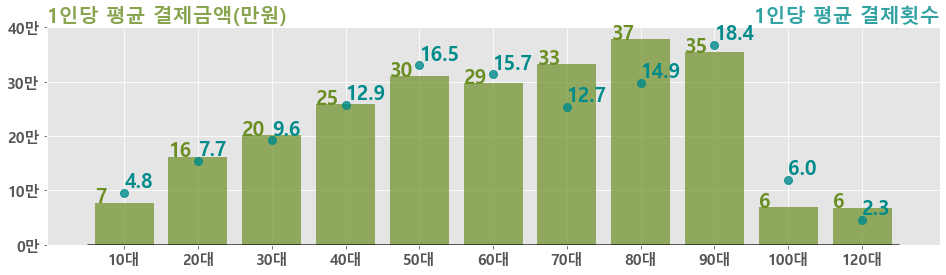

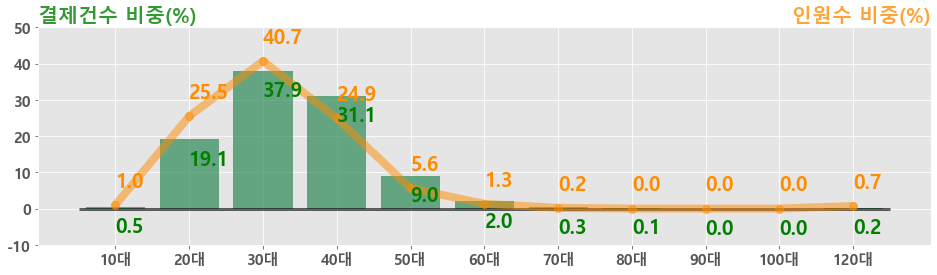

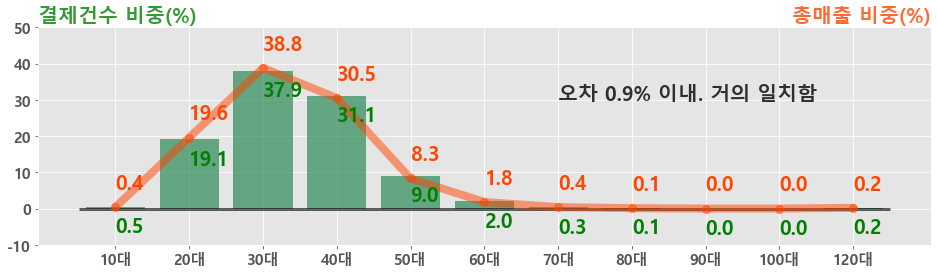

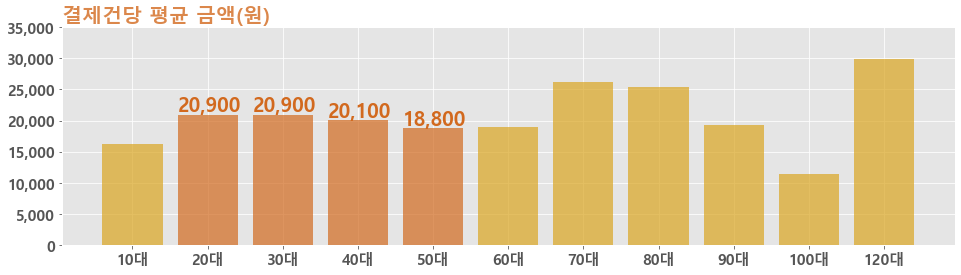

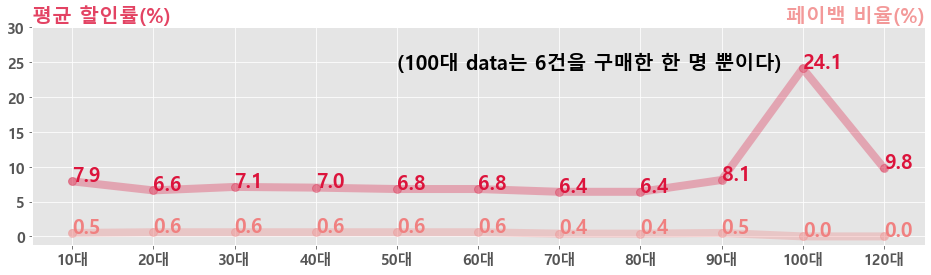

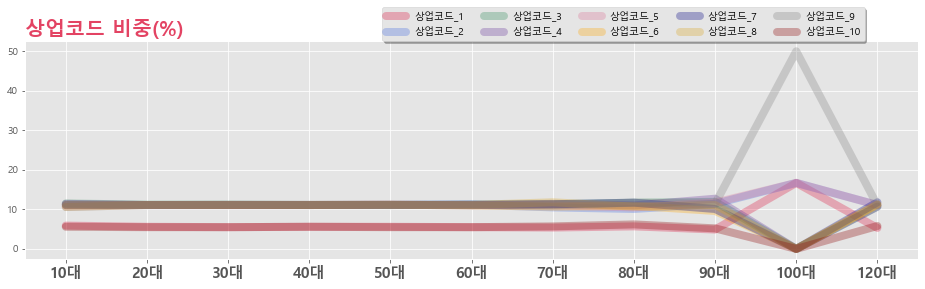

In [26]:
### (연령대별) 1인당 평균 결제금액 & 결제횟수
plt.figure(figsize=((16,4)))
x, y, y1 = range(11), data2.pm_before, [i//10000 for i in data2.pm_before]
plt.bar( x, y, color ='OliveDrab', alpha=0.7, )
plt.xticks( range(11), [f"{i}0대" for i in data2.AGE], size=15, weight=1000, )
plt.yticks( range(0,450000,100000), [f"{i}만" for i in range(0,45,10)], size=15, weight=1000, )
for i in range(11):
    plt.text( [i-0.4 for i in x][i], y[i], y1[i], size=20, color="OliveDrab", weight=1000, )
plt.hlines(0, -0.5, 10.5, color='k', alpha=0.6, linestyle='solid', linewidth=3, )
plt.title("1인당 평균 결제금액(만원)", weight=1000, color="OliveDrab", size=20, alpha=0.8, pad=-35, loc="left", )

y, y1, y0 = 20000*data2.buys, [20000*i+10000 for i in data2.buys], data2.buys
plt.plot( x, y, label="  ", alpha=0.8, lw=8, ls="", color ="DarkCyan", marker='o', ms=8, mfc="DarkCyan", solid_capstyle='round' )
plt.yticks( range(0,450000,100000), [f"{i}만" for i in range(0,45,10)], size=15, weight=1000, )
for i in range(11):
    plt.text( x[i], y1[i], y0[i], size=20, color="DarkCyan", weight=1000, )
plt.title("1인당 평균 결제횟수", weight=1000, color="DarkCyan", size=20, alpha=0.8, pad=-35, loc="right", )
plt.show()


### (연령대별) 결제건수 비중, 인원수 비중
plt.figure(figsize=((16,4)))
x, y, y1 = range(11), data2.rate_b, [i-7 for i in data2.rate_b]
plt.bar( x, y, color ='seagreen', alpha=0.7, )
plt.xticks( range(11), [f"{i}0대" for i in data2.AGE], size=15, weight=1000, )
plt.yticks( range(-10,60,10), size=15, weight=1000, )
for i in range(11):
    plt.text( x[i], y1[i], y[i], size=20, color="g", weight=1000, )
plt.hlines(0, -0.5, 10.5, color='k', alpha=0.6, linestyle='solid', linewidth=3, )
plt.title("결제건수 비중(%)", weight=1000, color="g", size=20, alpha=0.8, pad=-35, loc="left", )

y, y1 = data2.rate_p, [i+5 for i in data2.rate_p]
plt.plot( x, y, label="  ", alpha=0.5, lw=8, ls="-", color ="darkorange", marker='o', ms=8, mfc="darkorange", solid_capstyle='round' )
plt.yticks( range(-10,60,10), size=15, weight=1000, )
for i in range(11):
    plt.text( x[i], y1[i], y[i], size=20, color="darkorange", weight=1000, )
plt.title("인원수 비중(%)", weight=1000, color="darkorange", size=20, alpha=0.8, pad=-35, loc="right", )
plt.show()


### (연령대별) 결제건수 비중, 총매출 비중
plt.figure(figsize=((16,4)))
x, y, y1 = range(11), data2.rate_b, [i-7 for i in data2.rate_b]
plt.bar( x, y, color ='seagreen', alpha=0.7, )
plt.xticks( range(11), [f"{i}0대" for i in data2.AGE], size=15, weight=1000, )
plt.yticks( range(-10,60,10), size=15, weight=1000, )
for i in range(11):
    plt.text( x[i], y1[i], y[i], size=20, color="g", weight=1000, )
plt.text( 6, 30, "오차 0.9% 이내. 거의 일치함", size=20, color="k", alpha=0.8, weight=1000, )
plt.hlines(0, -0.5, 10.5, color='k', alpha=0.6, linestyle='solid', linewidth=3, )
plt.title("결제건수 비중(%)", weight=1000, color="g", size=20, alpha=0.8, pad=-35, loc="left", )

y, y1 = data2.rate_before, [i+5 for i in data2.rate_before]
plt.plot( x, y, label="  ", alpha=0.5, lw=8, ls="-", color ="OrangeRed", marker='o', ms=8, mfc="OrangeRed", solid_capstyle='round' )
plt.yticks( range(-10,60,10), size=15, weight=1000, )
for i in range(11):
    plt.text( x[i], y1[i], y[i], size=20, color="OrangeRed", weight=1000, )
plt.title("총매출 비중(%)", weight=1000, color="OrangeRed", size=20, alpha=0.8, pad=-35, loc="right", )
plt.show()


### (연령대별) 결제건당 평균 금액
plt.figure(figsize=((16,4)))
x, x1, y, y1, yp = range(11), [i-0.4 for i in range(11)], data2.bm_before, [i+500 for i in data2.bm_before], [f"{round(i,-2):,}" for i in data2.bm_before]
plt.bar( x, y, color =['GoldenRod']+["Chocolate"]*4+['GoldenRod']*6, alpha=0.7, )
plt.xticks( range(11), [f"{i}0대" for i in data2.AGE], size=15, weight=1000, )
plt.yticks( range(0,40000,5000), [f"{round(i,-2):,}" for i in range(0,40000,5000)], size=15, weight=1000, )
for i in range(1,5):
    plt.text( x1[i], y1[i], yp[i], size=20, color="Chocolate", weight=1000, )
plt.title("결제건당 평균 금액(원)", weight=1000, color="Chocolate", size=20, alpha=0.8, pad=-35, loc="left", )
plt.show()


### (연령대별) 1인당 평균 결제금액 & 결제횟수
plt.figure(figsize=((16,4)))
x, y, y1 = range(11), data2.rate_discnt, [i//10000 for i in data2.rate_discnt]
plt.plot( x, y, label="  ", alpha=0.3, lw=8, ls="-", color ="Crimson", marker='o', ms=8, mfc="Crimson", solid_capstyle='round' )
plt.xticks( range(11), [f"{i}0대" for i in data2.AGE], size=15, weight=1000, )
plt.yticks( range(0,35,5), size=15, weight=1000, )
for i in range(11):
    plt.text( x[i], y[i], y[i], size=20, color="Crimson", weight=1000, )
plt.text( 4, 24, "(100대 data는 6건을 구매한 한 명 뿐이다)", size=20, color="k", weight=1000, )
plt.title("평균 할인률(%)", weight=1000, color="Crimson", size=20, alpha=0.8, pad=-35, loc="left", )

y, y1 = data2.rate_back, [i//10000 for i in data2.rate_back]
plt.plot( x, y, label="  ", alpha=0.3, lw=8, ls="-", color ="LightCoral", marker='o', ms=8, mfc="LightCoral", solid_capstyle='round' )
plt.yticks( range(0,35,5), size=15, weight=1000, )
for i in range(11):
    plt.text( x[i], y[i], y[i], size=20, color="LightCoral", weight=1000, )
plt.title("페이백 비율(%)", weight=1000, color="LightCoral", size=20, alpha=0.8, pad=-35, loc="right", )
plt.show()

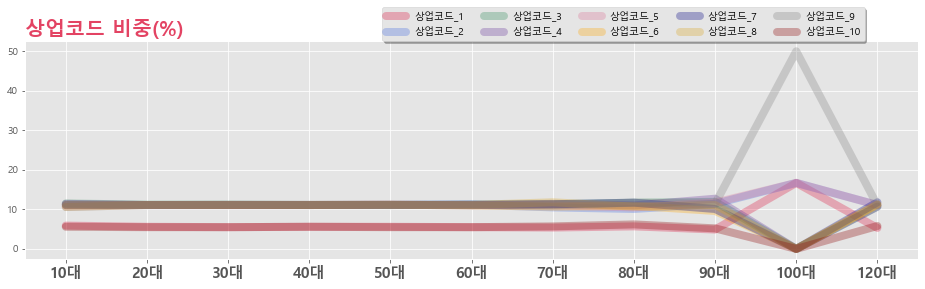

In [25]:
### (연령대별) 상업코드 비중
plt.figure(figsize=((16,4)))
x = range(11)
c = [0,"Crimson","RoyalBlue","SeaGreen","RebeccaPurple","PaleVioletRed","Orange","Navy","GoldenRod","Gray","DarkRed"]
for i in range(1,11):
    plt.plot( x, data2[f"rate_{i}"], label=f"상업코드_{i}", alpha=0.3, lw=8, ls="-", color =c[i], solid_capstyle='round' )
plt.plot( x, data2["rate_1"]+data2["rate_10"], label=f"상업코드_{i}", alpha=0.3, lw=8, ls="-", color =c[i], solid_capstyle='round' )

plt.xticks( range(11), [f"{i}0대" for i in data2.AGE], size=15, weight=1000, )
# plt.yticks( range(0,35,5), size=15, weight=1000, )
# for i in range(11):
#     plt.text( x[i], y[i], y[i], size=20, color="Crimson", weight=1000, )
# plt.text( 4, 24, "(100대 data는 6건을 구매한 한 명 뿐이다)", size=20, color="k", weight=1000, )
plt.title("상업코드 비중(%)", weight=1000, color="Crimson", size=20, alpha=0.8, pad=-35, loc="left", )
plt.legend(loc=(0.4,1), ncol=5, fontsize=10, frameon=True, shadow=True)
plt.show()